# try different supervised models and SFS,free based model importance
with 29 features, clinvar data

# train models with ML

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [42]:
df_3=pd.read_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_featureV1/01_preprocessed_data.csv')

## split test/train

In [43]:
## balance benign and pathogenic quantity

benign = df_3[df_3["CLNSIG"]==0]
pathogenic = df_3[df_3["CLNSIG"]==1]
benign = benign.sample(len(pathogenic),random_state=42)   # randomly extract benign same quantity with patho
data = pd.concat( (benign,pathogenic),axis=0,
    join="outer",
    ignore_index=False,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True)

In [14]:
data.columns[1:]

Index(['Consequence', 'IMPACT', 'BIOTYPE', 'SIFT', 'PolyPhen', 'SPIDEX_NAN',
       'SIFT_NAN', 'PolyPhen_NAN', 'REVEL_score_NAN',
       'SpliceAI_pred_DS_AG_NAN', 'ORIGIN_0', 'ORIGIN_1', 'ORIGIN_2',
       'ORIGIN_3', 'ORIGIN_4', 'ORIGIN_5', 'CADD', 'AF_TGP', 'Frq',
       'GNOMADAF_popmax', 'Hom', 'SPIDEX', 'SWEGENAF', 'MES-SWA_acceptor_alt',
       'MES-SWA_acceptor_diff', 'MES-SWA_donor_alt', 'MES-SWA_donor_diff',
       'MaxEntScan_alt', 'MaxEntScan_diff', 'GERP++_RS', 'REVEL_score',
       'phastCons100way_vertebrate', 'phyloP100way_vertebrate', 'LoFtool',
       'pLI_gene_value', 'SpliceAI_pred_DS_AG', 'SpliceAI_pred_DS_AL',
       'SpliceAI_pred_DS_DG', 'SpliceAI_pred_DS_DL'],
      dtype='object')

In [45]:
from sklearn.model_selection import train_test_split
X, y = data.iloc[:, 1:].values, data.iloc[:, 0].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                    test_size=0.3,
                    random_state=42,
                    stratify=y)

In [6]:
X_train.shape

(143434, 39)

##  train models

In [7]:
import mglearn   # lizard book's library for plots    # pip install mglearn

In [46]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

#### 1. k-Nearest Neighbors
classifier   k-NN
slower, 16mins ! bad for much 0, much features

In [10]:
from sklearn.neighbors import KNeighborsClassifier


clf = KNeighborsClassifier(n_neighbors=3) 
clf.fit(X_train, y_train)
# predictions = clf.predict(X_test)
    # record training set accuracy
print("Training set score: {:.4f}".format(clf.score(X_train, y_train))) 
print("Test set score: {:.4f}".format(clf.score(X_test, y_test)))

Training set score: 0.9829
Test set score: 0.9745


In [49]:
## save model
import joblib

joblib.dump(clf,'KNN_featsV1_model.sav')

# test = joblib.load('KNN_featsV1_model.sav')    # load back
# test.score(X_test, y_test)

['KNN_featsV1_model.sav']

for ROC curve

In [14]:
prob1 = clf.predict_proba(X_test)
prob1 = prob1[:,1]     # choose the 2nd column --class 1 pathogenic
fprKn, tprKn, thresholdsKn = roc_curve(y_test, prob1)

#### 2. linear regression 
Ridge regression alternatives to standard 

In [ ]:
# linear regression   no parameter can adjust
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train, y_train)
print("Training set score: {:.5f}".format(lr.score(X_train, y_train))) 
print("Test set score: {:.5f}".format(lr.score(X_test, y_test)))

In [24]:
# Ridge regression : the default parameter alpha=1.0

from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0).fit(X_train, y_train)
print("Training set score: {:.2f}".format(ridge.score(X_train, y_train))) 
print("Test set score: {:.2f}".format(ridge.score(X_test, y_test)))

Training set score: 0.86
Test set score: 0.86


#### 3. logistic regression

In [16]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)   # max iteration to finish converage: max_iter=1000 , C =1 
print("Training set score: {:.3f}".format(logreg.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg.score(X_test, y_test)))

Training set score: 0.978
Test set score: 0.978


In [54]:
## save model

joblib.dump(logreg,'logistic_featsV1_model.sav')

# test = joblib.load('KNN_featsV1_model.sav')    # load back
# test.score(X_test, y_test)

['logistic_featsV1_model.sav']

In [17]:
## for ROC
prob2 = logreg.predict_proba(X_test)
prob2 = prob2[:,1]     # choose the 2nd column --class 1 pathogenic
fprLg, tprLg, thresholdsLg = roc_curve(y_test, prob2)

In [20]:
logreg100 = LogisticRegression(C=100,max_iter=1000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg100.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg100.score(X_test, y_test)))

Training set score: 0.979
Test set score: 0.978


In [63]:
logreg001 = LogisticRegression(C=0.01,max_iter=1000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(logreg001.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(logreg001.score(X_test, y_test)))

Training set score: 0.978
Test set score: 0.977


3.1 feature selection

1) sequential feature select
    [http://rasbt.github.io/mlxtend/user_guide/feature_selection/](http://rasbt.github.io/mlxtend/user_guide/feature_selection/)

In [13]:
X.shape[1]

39

In [16]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# forward
## very slow: 71m

sfs1 = SFS(logreg, 
           k_features=39, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=2,
           n_jobs=-1)

sfs1 = sfs1.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  39 out of  39 | elapsed:    2.8s finished

[2023-03-23 22:33:43] Features: 1/39 -- score: 0.9524521314273284[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  38 | elapsed:    1.7s finished

[2023-03-23 22:33:45] Features: 2/39 -- score: 0.9604195367359574[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 out of  37 | elapsed:    2.4s finished

[2023-03-23 22:33:47] Features: 3/39 -- score: 0.9683451110751675[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:    3.9s finished

[2023-03-23 22:33:51] Features: 4/39 -- score: 0.9695721528447848[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    5.3s finished



In [45]:
df_sfs_logistic = pd.DataFrame.from_dict(sfs1.get_metric_dict()).T
df_sfs_logistic

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(16,)","[0.9535732014077516, 0.9513310614469054]",0.952452,"(16,)",0.004824,0.001121,0.001121
2,"(16, 19)","[0.9623688599108722, 0.9584702135610426]",0.96042,"(16, 19)",0.008387,0.001949,0.001949
3,"(0, 16, 19)","[0.9694801247120635, 0.9672100974382715]",0.968345,"(0, 16, 19)",0.004884,0.001135,0.001135
4,"(0, 14, 16, 19)","[0.9706904340939133, 0.9684538715956563]",0.969572,"(0, 14, 16, 19)",0.004812,0.001118,0.001118
5,"(0, 14, 16, 17, 19)","[0.9712258705024736, 0.9700434484335696]",0.970635,"(0, 14, 16, 17, 19)",0.002544,0.000591,0.000591
6,"(0, 8, 14, 16, 17, 19)","[0.9715772506455913, 0.9707629411075726]",0.97117,"(0, 8, 14, 16, 17, 19)",0.001752,0.000407,0.000407
7,"(0, 8, 14, 16, 17, 19, 30)","[0.9766638965269141, 0.9758997841521978]",0.976282,"(0, 8, 14, 16, 17, 19, 30)",0.001644,0.000382,0.000382
8,"(0, 8, 14, 15, 16, 17, 19, 30)","[0.9772997272620794, 0.9765133050370065]",0.976907,"(0, 8, 14, 15, 16, 17, 19, 30)",0.001692,0.000393,0.000393
9,"(0, 8, 14, 15, 16, 17, 19, 28, 30)","[0.9775674454663595, 0.977288572336901]",0.977428,"(0, 8, 14, 15, 16, 17, 19, 28, 30)",0.0006,0.000139,0.000139
10,"(0, 2, 8, 14, 15, 16, 17, 19, 28, 30)","[0.9779411354598339, 0.9774893609901112]",0.977715,"(0, 2, 8, 14, 15, 16, 17, 19, 28, 30)",0.000972,0.000226,0.000226


In [44]:
df_sfs_logistic.to_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_feature/02_sfs_logistic.csv')

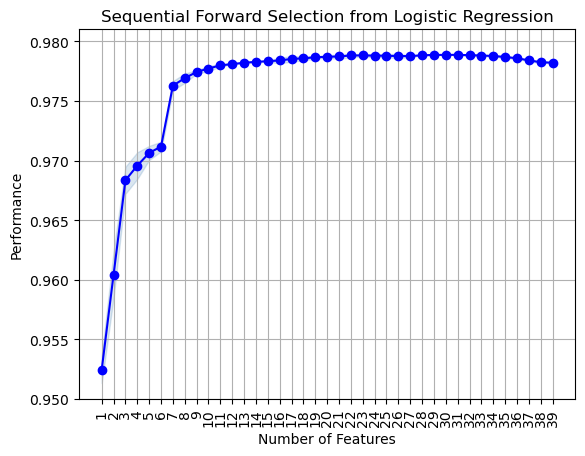

In [115]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.95, 0.981])
plt.title('Sequential Forward Selection from Logistic Regression')
plt.xticks(rotation=90)
plt.grid()
# plt.show()
plt.show()

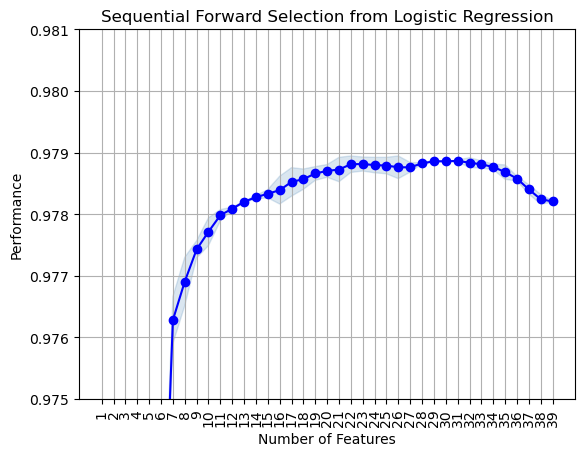

In [116]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

fig1 = plot_sfs(sfs1.get_metric_dict(), kind='std_dev')

plt.ylim([0.975, 0.981])
plt.title('Sequential Forward Selection from Logistic Regression')
plt.xticks(rotation=90)
plt.grid()
plt.show()

In [71]:
# got subset details
# 
sfs1.subsets_ [7]     

{'feature_idx': (0, 8, 14, 16, 17, 19, 30),
 'cv_scores': array([0.9766639 , 0.97589978]),
 'avg_score': 0.9762818403395559,
 'feature_names': ('0', '8', '14', '16', '17', '19', '30')}

In [72]:
sfs1.subsets_ [8] 

{'feature_idx': (0, 8, 14, 15, 16, 17, 19, 30),
 'cv_scores': array([0.97729973, 0.97651331]),
 'avg_score': 0.9769065161495429,
 'feature_names': ('0', '8', '14', '15', '16', '17', '19', '30')}

In [73]:
sfs1.subsets_ [9] 

{'feature_idx': (0, 8, 14, 15, 16, 17, 19, 28, 30),
 'cv_scores': array([0.97756745, 0.97728857]),
 'avg_score': 0.9774280089016303,
 'feature_names': ('0', '8', '14', '15', '16', '17', '19', '28', '30')}

In [74]:
sfs1.subsets_ [10] 

{'feature_idx': (0, 2, 8, 14, 15, 16, 17, 19, 28, 30),
 'cv_scores': array([0.97794114, 0.97748936]),
 'avg_score': 0.9777152482249725,
 'feature_names': ('0', '2', '8', '14', '15', '16', '17', '19', '28', '30')}

In [81]:
sfs1.subsets_ [11]['feature_idx']

(0, 2, 8, 14, 15, 16, 17, 19, 28, 30, 38)

In [ ]:
## get the features name with index     in dic
feature_names = data.columns[1:]
dic_f=dict(enumerate(feature_names))
dic_f

In [114]:
### get the feature subsets 7-11 with higher accuracy, names and indice
subsets = [7,8,9,10,11,22]
feature_selection= [[] for i in range(6)]     # initialize a nested list  https://www.freecodecamp.org/news/list-within-a-list-in-python-initialize-a-nested-list/
a=0

for i in subsets:
    
    for j in (sfs1.subsets_[i]['feature_idx']):
        feature_selection[a].append(dic_f[j])

    a+=1

feature_selection



[['Consequence',
  'REVEL_score_NAN',
  'ORIGIN_4',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'REVEL_score'],
 ['Consequence',
  'REVEL_score_NAN',
  'ORIGIN_4',
  'ORIGIN_5',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'REVEL_score'],
 ['Consequence',
  'REVEL_score_NAN',
  'ORIGIN_4',
  'ORIGIN_5',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'MaxEntScan_diff',
  'REVEL_score'],
 ['Consequence',
  'BIOTYPE',
  'REVEL_score_NAN',
  'ORIGIN_4',
  'ORIGIN_5',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'MaxEntScan_diff',
  'REVEL_score'],
 ['Consequence',
  'BIOTYPE',
  'REVEL_score_NAN',
  'ORIGIN_4',
  'ORIGIN_5',
  'CADD',
  'AF_TGP',
  'GNOMADAF_popmax',
  'MaxEntScan_diff',
  'REVEL_score',
  'SpliceAI_pred_DS_DL'],
 ['Consequence',
  'IMPACT',
  'BIOTYPE',
  'REVEL_score_NAN',
  'ORIGIN_1',
  'ORIGIN_4',
  'ORIGIN_5',
  'CADD',
  'AF_TGP',
  'Frq',
  'GNOMADAF_popmax',
  'Hom',
  'SWEGENAF',
  'MES-SWA_acceptor_diff',
  'MES-SWA_donor_alt',
  'MES-SWA_donor_diff',
  'MaxEntSc

Using the Selected Feature Subset For Making New Predictions

In [107]:
feature_select_idx = sfs1.subsets_ [7]['feature_idx']

X_train_sfs = X_train[:, feature_select_idx]
X_test_sfs = X_test[:, feature_select_idx]
# X_train_sfs.shape

logreg_sfs = LogisticRegression(max_iter=1000).fit(X_train_sfs, y_train)   # max iteration to finish converage: max_iter=1000 , C =1 

y_pred = logreg_sfs.predict(X_test_sfs)

# Compute the accuracy of the prediction
acc = float((y_test == y_pred).sum()) / y_pred.shape[0]
print('Test set accuracy: %.2f %%' % (acc * 100))

Test set accuracy: 97.61 %


3.2 Stratified k-Fold Cross-Validation

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    score = logreg.score(X_train[test], y_train[test]) 
    scores.append(score)
    
    # print(f'Fold: {k+1:02d}, ' 
    # f'Acc.: {score:.3f}')


In [91]:
print(f'Fold scores: {scores}\n')
print(f'CV accuracy: {np.mean(scores):.3f} '
f'+/- {np.std(scores):.3f}')

Fold scores: [0.97678390908774, 0.978910307804929, 0.9797120646982954, 0.9773067940181964, 0.9791891797678391, 0.9790497437863841, 0.9777251019625615, 0.9772370760274689, 0.9788049919821515, 0.9805131422993795]

CV accuracy: 0.979 +/- 0.001


3.3 extract test data with prob of pathogenic
for distribution plot by R

In [31]:
prob = logreg.predict_proba(X_test)    # 1st column: class 0;  2nd column: class 1
# prob [0:3,:]
prob [:,1]     # the 2nd column number represent the pathogenic class prob

array([0.97827072, 0.97619797, 0.99981395, ..., 0.99151317, 0.89716727,
       0.00253891])

In [50]:
# transfer array to dataframe
logistic_prob = pd.DataFrame(data = [prob [:,1], y_test]).T
logistic_prob.columns=['prob_logistic','CLNSIG']

# logistic_prob.to_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_feature/01_logistic_prob.csv',index=False)

#### 4. Linear SVM
more than 1min

In [ ]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC(max_iter=1000).fit(X_train, y_train)
print("Training set score: {:.3f}".format(linear_svm.score(X_train, y_train))) 
print("Test set score: {:.3f}".format(linear_svm.score(X_test, y_test)))

#### 5.decision tree

In [19]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))


Accuracy on training set: 1.000
Accuracy on test set: 0.979


In [55]:
## save model

joblib.dump(tree,'decision_featsV1_model.sav')

['decision_featsV1_model.sav']

In [20]:
## for ROC
prob3 = tree.predict_proba(X_test)
prob3 = prob3[:,1]
fprDt, tprDt, thresholdsDt = roc_curve(y_test, prob3)

In [46]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(max_depth=6, random_state=0)  # stop building the tree after a certain depth
tree.fit(X_train, y_train)
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, y_train))) 
print("Accuracy on test set: {:.3f}".format(tree.score(X_test, y_test)))

Accuracy on training set: 0.984
Accuracy on test set: 0.981


In [ ]:
data.columns

In [164]:
# feature importance in tree
print("Feature importances:\n{}".format(tree.feature_importances_))


Feature importances:
[4.51899500e-02 2.23794343e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.96619007e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.33564739e-03 0.00000000e+00 1.81993703e-03 2.55176197e-03
 8.75194382e-01 5.15295388e-04 6.89105324e-03 5.52336658e-02
 2.46169980e-05 8.92342274e-05 2.80715698e-05 0.00000000e+00
 2.38088882e-05 2.43539122e-04 1.35644877e-05 0.00000000e+00
 0.00000000e+00 2.82118762e-05 7.55913819e-03 2.85339849e-04
 0.00000000e+00 0.00000000e+00 3.18665198e-04 7.78887573e-04
 7.54815396e-04 0.00000000e+00 0.00000000e+00]


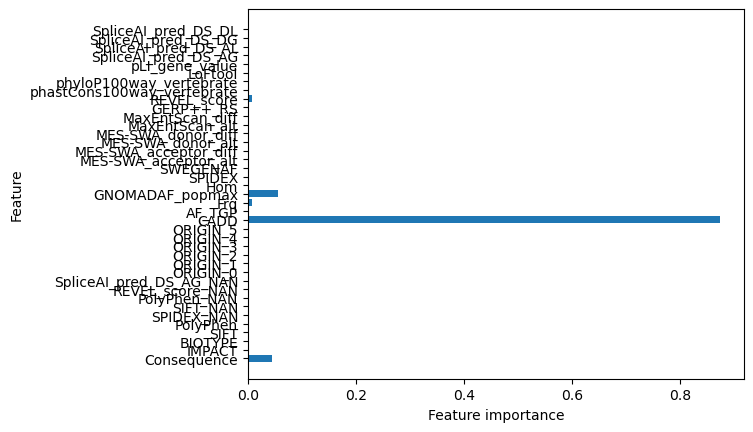

In [166]:
# plot :feature importance in tree

def plot_feature_importances_cancer(model): 
    n_features = data.shape[1] - 1
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), data.columns[1:])
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
plot_feature_importances_cancer(tree)

#### 6. random forest
also for select feature importance
3mins

In [21]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=600,random_state=1) 
forest.fit(X_train, y_train)
print("Accuracy on training set: {:f}".format(forest.score(X_train, y_train))) 
print("Accuracy on test set: {:f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000000
Accuracy on test set: 0.987339


In [47]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10).split(X_train, y_train)

scores = []
for k, (train, test) in enumerate(kfold):
    forestK = RandomForestClassifier(n_estimators=600,random_state=1).fit(X_train, y_train)
    score = forestK.score(X_train[test], y_train[test]) 
    scores.append(score)
    
    # print(f'Fold: {k+1:02d}, ' 
    # f'Acc.: {score:.3f}')

print(f'Fold scores: {scores}\n')
print(f'CV accuracy: {np.mean(scores):.3f} '
f'+/- {np.std(scores):.3f}')

Fold scores: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

CV accuracy: 1.000 +/- 0.000


In [22]:
## for ROC curve
prob4 = forest.predict_proba(X_test)
prob4 = prob4[:,1]
fprRf, tprRf, thresholdsRf = roc_curve(y_test, prob4)

 extract test data with prob of pathogenic
for distribution plot by R

In [73]:
## get prob

prob_f = forest.predict_proba(X_test)    # 1st column: class 0;  2nd column: class 1
# prob [0:3,:]
prob_f[:,1]     # the 2nd column number represent the pathogenic class prob

# transfer array to dataframe
all_prob = pd.DataFrame(data = [prob [:,1], prob_f [:,1]]).T
all_prob.columns=['prob_logistic','prob_randomforest']

# get the class label back
Clnsig = pd.DataFrame(y_test, columns=['CLNSIG'])
map_clnsig={1:'pathogenic', 0:'benign'}
Clnsig['CLNSIG']=Clnsig['CLNSIG'].map(lambda s: map_clnsig.get(s) if s in map_clnsig else s)
# Clnsig["CLNSIG"].unique()

#  merge with prob
model_prob = pd.concat([Clnsig,all_prob],axis=1)
model_prob

model_prob.to_csv('/Users/nancy/Desktop/RS_projects/data/03_ML/01_feature/01_model_prob.csv',index=False)

feature importance in tree:

In [50]:
# #  
##  aggregating the feature importances over the trees in the forest. more reliable than single tree

feat_labels = data.columns[1:]     
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1] 
for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,
                             feat_labels[indices[f]],importances[indices[f]]))       ## rank feature importance

 1) CADD                           0.245681
 2) IMPACT                         0.216953
 3) Consequence                    0.201149
 4) GNOMADAF_popmax                0.061220
 5) Frq                            0.046685
 6) phastCons100way_vertebrate     0.024255
 7) REVEL_score                    0.022058
 8) SPIDEX                         0.020055
 9) GERP++_RS                      0.018628
10) phyloP100way_vertebrate        0.015177
11) AF_TGP                         0.015115
12) SPIDEX_NAN                     0.011426
13) Hom                            0.009882
14) MaxEntScan_diff                0.009563
15) SWEGENAF                       0.007765
16) MaxEntScan_alt                 0.005972
17) ORIGIN_4                       0.005897
18) PolyPhen                       0.005259
19) SIFT                           0.005071
20) MES-SWA_donor_diff             0.005067
21) MES-SWA_donor_alt              0.004894
22) SpliceAI_pred_DS_DL            0.004813
23) MES-SWA_acceptor_diff       

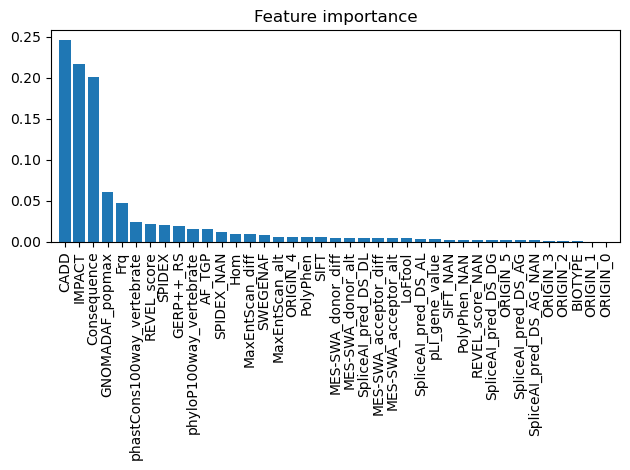

In [57]:
# plot_feature_importances

plt.title('Feature importance') 
plt.bar(range(X_train.shape[1]),
        importances[indices], 
        align='center')
plt.xticks(range(X_train.shape[1]),
            feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]]) 
plt.tight_layout()
plt.show()

## plot ROC curve together, 4 models
KNN, logitic regression, decision tree, radom forest
(linear SVM , linear regression don't have proba)

In [23]:
import sklearn.metrics as metrics

roc_Kn = metrics.auc(fprKn,tprKn)
roc_Lg = metrics.auc(fprLg,tprLg)
roc_Dt = metrics.auc(fprDt,tprDt)
roc_Rf = metrics.auc(fprRf,tprRf)

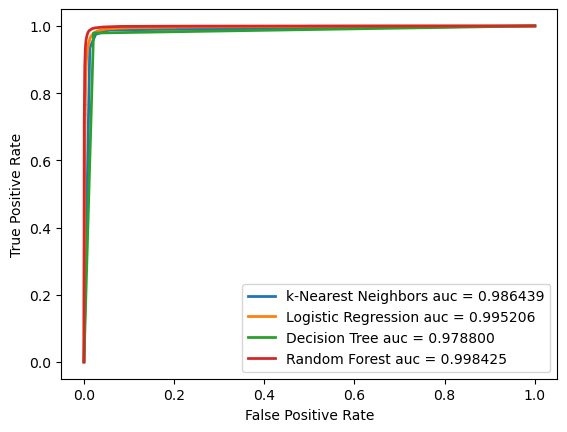

In [40]:
plt.plot(fprKn, tprKn, label='k-Nearest Neighbors'+ ' auc = ' + str("%.6f" % roc_Kn),linewidth=2)
plt.plot(fprLg, tprLg, label='Logistic Regression'+ ' auc = ' + str("%.6f" % roc_Lg),linewidth=2)
plt.plot(fprDt, tprDt, label='Decision Tree' + ' auc = ' + str("%.6f" % roc_Dt), linewidth=2)
plt.plot(fprRf, tprRf, label='Random Forest' + ' auc = ' + str("%.6f" % roc_Rf), linewidth=2)

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()

# show the plot
plt.show()